# Data Exploration

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
import warnings

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# import statsmodels.api as sm
from scipy import stats
from datetime import datetime, timedelta
import plotly.graph_objects as go

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
# print('Tensorflow version: ', tensorflow.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/My Drive/BTFEEDleftmenu.csv"
df = pd.read_csv(PATH)
df.shape

(31808404, 6)

Convert timestamp to date

In [ ]:
df['timestamp'] = df['event_start_epoc'].apply(lambda ts: datetime.fromtimestamp(ts))  
df

,response_time,event_start_ms,event_start_epoc,year,month,day,timestamp
0,8.674542,564,1544956946,2018,12,16,2018-12-16 10:42:26
1,8.994416,388,1544956946,2018,12,16,2018-12-16 10:42:26
2,10.833192,493,1544956945,2018,12,16,2018-12-16 10:42:25
3,18.026684,315,1544956945,2018,12,16,2018-12-16 10:42:25
4,10.089430,32,1544956945,2018,12,16,2018-12-16 10:42:25
...,...,...,...,...,...,...,...
31808399,195.648865,495,1534143785,2018,8,13,2018-08-13 07:03:05
31808400,27.104675,686,1534143785,2018,8,13,2018-08-13 07:03:05
31808401,14.812492,707,1534143785,2018,8,13,2018-08-13 07:03:05
31808402,11.833150,765,1534143785,2018,8,13,2018-08-13 07:03:05


In [ ]:
df.columns

Index(['response_time', 'event_start_ms', 'event_start_epoc', 'year', 'month',
       'day', 'timestamp'],
      dtype='object')

In [ ]:
df.dtypes

response_time              float64
event_start_ms               int64
event_start_epoc             int64
year                         int64
month                        int64
day                          int64
timestamp           datetime64[ns]
dtype: object

In [ ]:
df['year'].unique()

array([2018, 2019])

In [ ]:
df['month'].unique()

array([12,  2,  8,  1,  6,  7, 10,  5, 11,  9,  3,  4])

In [ ]:
df['day'].unique()

array([16, 12, 26, 28,  7, 10, 22,  9,  2, 23, 31, 17, 24,  8, 30, 14, 20,
        5,  3,  6, 25, 11, 13,  4, 18, 19, 29, 27,  1, 21, 15])

In [ ]:
df['event_start_ms'].describe()

count    3.180840e+07
mean     5.001951e+02
std      2.883423e+02
min      0.000000e+00
25%      2.510000e+02
50%      5.000000e+02
75%      7.500000e+02
max      9.990000e+02
Name: event_start_ms, dtype: float64

Histogram

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


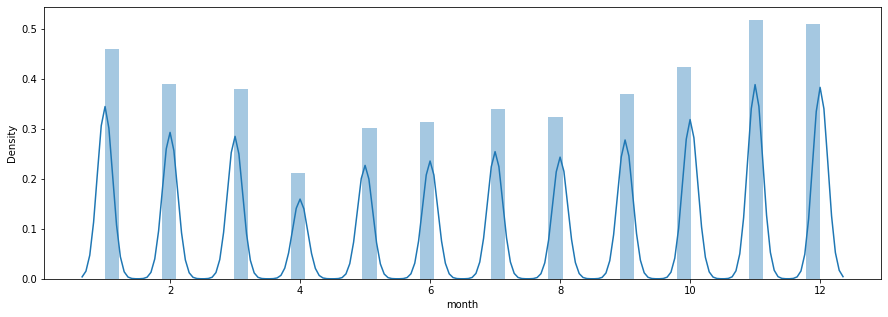

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.distplot(df['month']);    # displot, histplot

**Normal probability plot** Data distribution should closely follow the diagonal that represents the normal distribution

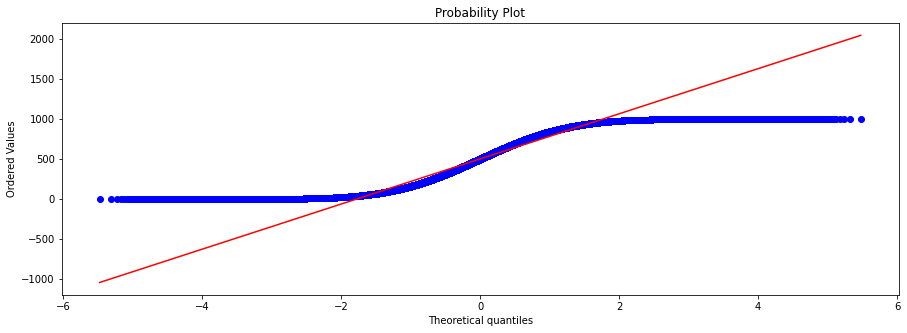

In [ ]:
fig = plt.figure(figsize=(15,5))
res = stats.probplot(df['event_start_ms'], plot=plt)

Checking empty values

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
total

timestamp           0
day                 0
month               0
year                0
event_start_epoc    0
event_start_ms      0
response_time       0
dtype: int64

In [ ]:
df.head(2000).to_csv('operational_log.csv', index=True)

In [ ]:
PATH = "operational_log.csv"
df_log = pd.read_csv(PATH)
df_log.head()

,Unnamed: 0,response_time,event_start_ms,event_start_epoc,year,month,day,timestamp
0,0,8.674542,564,1544956946,2018,12,16,2018-12-16 10:42:26
1,1,8.994416,388,1544956946,2018,12,16,2018-12-16 10:42:26
2,2,10.833192,493,1544956945,2018,12,16,2018-12-16 10:42:25
3,3,18.026684,315,1544956945,2018,12,16,2018-12-16 10:42:25
4,4,10.089430,32,1544956945,2018,12,16,2018-12-16 10:42:25


In [ ]:
df_log.shape

(20000, 7)

In [ ]:
df_log['response_time'].min(), df_log['response_time'].max()

(2.290298700332642, 24426.7109375)

In [ ]:
df_log['event_start_ms'].min(), df_log['event_start_ms'].max()

(0, 999)

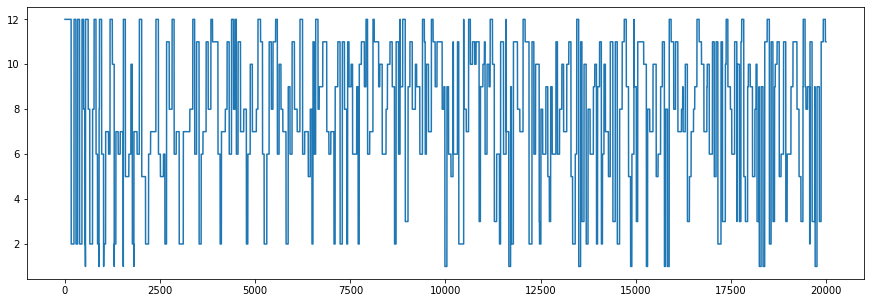

In [ ]:
fig = plt.figure(figsize=(15,5))
df_log['month'].plot()
plt.show()

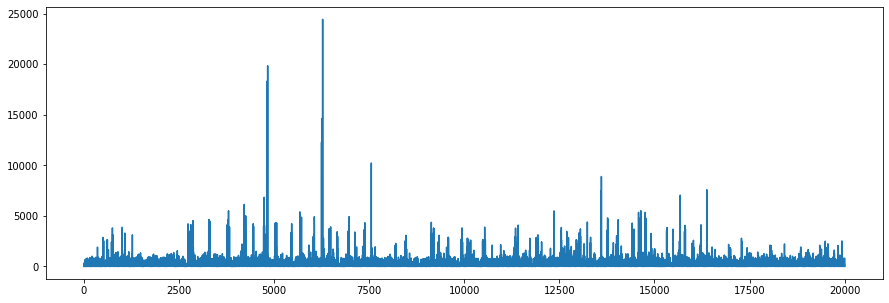

In [ ]:
fig = plt.figure(figsize=(15,5))
df_log['response_time'].plot()
plt.show()

**Drop duplicates**

In [ ]:
df_log = df_log.drop_duplicates()
df_log.shape

(20000, 7)

In [ ]:
df_log_rt = df_log[['timestamp', 'response_time']]
df_log_rt

,timestamp,response_time
0,2018-12-16 10:42:26,8.674542
1,2018-12-16 10:42:26,8.994416
2,2018-12-16 10:42:25,10.833192
3,2018-12-16 10:42:25,18.026684
4,2018-12-16 10:42:25,10.089430
...,...,...
19995,2018-11-24 20:43:28,22.582991
19996,2018-11-24 20:43:26,822.168564
19997,2018-11-24 20:43:28,9.834566
19998,2018-11-24 20:43:27,11.340903


In [ ]:
df_log_rt['timestamp'].min(), df_log_rt['timestamp'].max()

('2018-05-12 02:09:37', '2019-03-26 08:45:18')

**Visualize the timeseries**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_log_rt['timestamp'], y=df_log_rt['response_time'], name='response time'))
fig.update_layout(showlegend=True, title='Visualize the timeseries for response time')
fig.show()

In [ ]:
df_log_es = df_log[['timestamp', 'event_start_ms']]
df_log_es

,timestamp,event_start_ms
0,2018-12-16 10:42:26,564
1,2018-12-16 10:42:26,388
2,2018-12-16 10:42:25,493
3,2018-12-16 10:42:25,315
4,2018-12-16 10:42:25,32
...,...,...
19995,2018-11-24 20:43:28,41
19996,2018-11-24 20:43:26,64
19997,2018-11-24 20:43:28,19
19998,2018-11-24 20:43:27,673


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_log_es['timestamp'], y=df_log_es['event_start_ms'], name='event start'))
fig.update_layout(showlegend=True, title='Visualize the timeseries for event start')
fig.show()